# EIO - Implementacja drzew decyzyjnych

Autorzy: Dariusz Max Adamski, Sławomir Gilewski

---

In [2]:
import numpy as np
import pandas as pd
import graphviz

In [3]:
data = pd.read_csv('titanic.csv').drop(columns=['PassengerId', 'Name'])
label = 'Survived'
X = data[set(data.columns) - {label}]
y = data[label]
data

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,male,22,1,0,0
1,1,female,38,1,0,1
2,3,female,26,0,0,1
3,1,female,35,1,0,1
4,3,male,35,0,0,0
...,...,...,...,...,...,...
95,3,male,44,0,0,0
96,1,male,71,0,0,0
97,1,male,23,0,1,1
98,2,female,34,0,1,1


In [4]:
def entropy(S):
    P = [np.mean(S == xi) for xi in np.unique(S)]
    return -np.sum(P * np.log2(P))

def cond_entropy(S, A):
    S = np.array(S)
    A = np.array(A)
    return np.sum([np.mean(S == s) * entropy(A[S == s]) for s in np.unique(S)])

def gain_ratio(S, A):
    gain = entropy(A) - cond_entropy(S, A)
    info = entropy(S)
    if info == 0: return gain
    return gain / info

def splits(X, y):
    pairs = sorted(zip(X, y), key=lambda x: x[0])
    last_value, last_label = pairs[0]
    values = []
    for value, label in pairs[1:]:
        if last_label != label:
            last_label = label
            values.append((last_value + value) / 2)
        last_value = value
    return values

def best_column(X, y, numerical):
    result = []
    for column in X.columns:
        if column in numerical:
            for split in splits(X[column], y):
                X_split = X[column].map(lambda it: f'<{split}' if it < split else f'>={split}')
                score = gain_ratio(X_split, y)
                result.append((column, score, split, X_split))
        else:
            result.append((column, gain_ratio(X[column], y), None, X[column]))
    return max(result, key=lambda x: x[1])

def id3(X, y, numerical=[], drop_numerical=False):
    if len(y.unique()) == 1:
        # only one label left, return a leaf
        return (str(y.unique()[0]), [])
    if len(X.columns) == 0:
        # no more columns to split on, give up and write the number of each class in the leaf
        counts = ', '.join(f'{x} ({n})' for x, n in y.value_counts().items())
        return (counts, [])
    best, score, split, X_best = best_column(X, y, numerical)
    nodes = []
    for value in np.unique(X_best):
        mask = X_best == value
        cols = set(X.columns)
        if drop_numerical or best not in numerical:
            cols -= {best}
        node = id3(X[cols][mask], y[mask], numerical, drop_numerical)
        nodes.append((value, node))
    return (best, nodes)

def draw_tree(tree):
    def draw_tree_rec(tree, path=[]):
        name, nodes = tree
        src = '/'.join(path)
        dot.node(src, label=name, color='green' if not nodes else None)
        for value, node in nodes:
            path_next = path + [name, f'{value}']
            dst = '/'.join(path_next)
            dot.edge(src, dst, label=f'{value}')
            draw_tree_rec(node, path_next)
    dot = graphviz.Digraph()
    dot.format = 'png'
    draw_tree_rec(tree)
    return dot

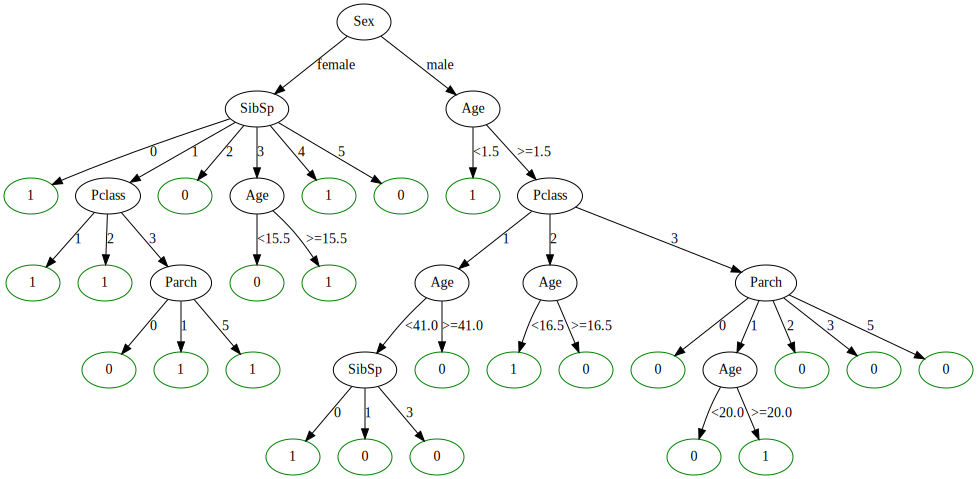

In [5]:
draw_tree(id3(X, y, numerical=['Age'], drop_numerical=False))

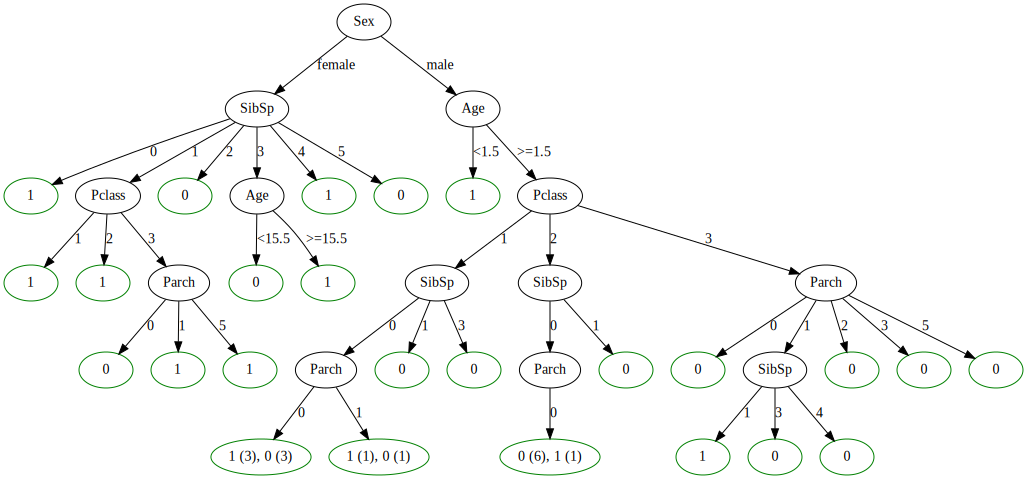

In [6]:
draw_tree(id3(X, y, numerical=['Age'], drop_numerical=True))

In [ ]:
data